In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import amp 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [ ]:
# import os
# import shutil

# source_base = "./Gatos"
# # Carpeta destino donde irá todo plano
# target_base = "data/cats_dataset/cat"

# os.makedirs(target_base, exist_ok=True)

# for folder in os.listdir(source_base):
#     subfolder_path = os.path.join(source_base, folder)
#     if os.path.isdir(subfolder_path) and folder.startswith("CAT_"):
#         for file in os.listdir(subfolder_path):
#             if file.lower().endswith(".jpg"):
#                 source_file = os.path.join(subfolder_path, file)
#                 target_file = os.path.join(target_base, f"{folder}_{file}")
#                 shutil.copy2(source_file, target_file)

# print("✅ Reorganización completada.")


✅ Reorganización completada.


In [ ]:
# import onnxruntime as ort

# providers = ort.get_available_providers()
# print("🚀 ORT Providers disponibles:", providers)

🚀 ORT Providers disponibles: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [ ]:
# import os
# import rembg
# from PIL import Image
# from rembg import remove
# from ultralytics import YOLO
# import cv2

# # Rutas
# input_folder = "data/cats_dataset/cat"
# output_folder = "data/cats_dataset_cleaned"
# os.makedirs(output_folder, exist_ok=True)

# # Cargar modelo YOLOv8 preentrenado (usa el modelo "n" para mayor velocidad)
# model = YOLO('yolov8n.pt')

# # ID de clase para gatos en COCO (15)
# cat_class_id = 15

# # Procesar cada imagen
# for filename in os.listdir(input_folder):
#     if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
#         image_path = os.path.join(input_folder, filename)
        
#         # Leer imagen
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
        
#         # Ejecutar YOLO
#         results = model(image)

#         for i, box in enumerate(results[0].boxes):
#             class_id = int(box.cls)
#             if class_id == cat_class_id:
#                 x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
#                 cat_crop = image[y1:y2, x1:x2]

#                 # Guardar crop temporal como imagen PIL
#                 cat_img = Image.fromarray(cv2.cvtColor(cat_crop, cv2.COLOR_BGR2RGB))

#                 # Remover fondo
#                 cat_no_bg = remove(cat_img)

#                 # Guardar imagen sin fondo
#                 output_path = os.path.join(output_folder, f'{os.path.splitext(filename)[0]}_cat_{i}.png')
#                 cat_no_bg.save(output_path)

# print("✅ Proceso terminado. Imágenes sin fondo guardadas en:", output_folder)


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_size = 128 #---------------------------------
batch_size = 128

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

dataset = datasets.ImageFolder(root="data/cats_dataset_cleaned", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Total de imágenes cargadas: {len(dataset)}")


Total de imágenes cargadas: 3980



Mostrando algunas imágenes del dataset:


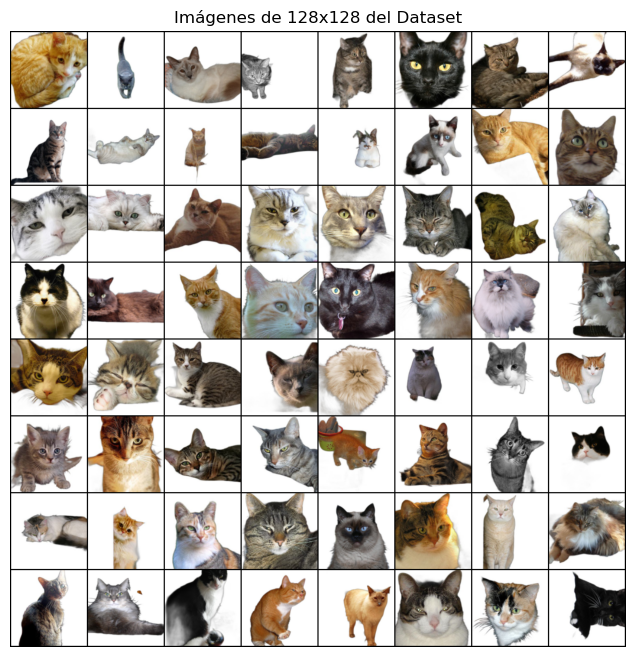

In [3]:
def show_images(dataloader, num_images=64):
    # Obtener un batch de imágenes
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Las imágenes están normalizadas a [-1, 1], hay que desnormalizarlas a [0, 1]
    # (x * 0.5) + 0.5
    images = images * 0.5 + 0.5

    # Crear un grid de imágenes
    grid = vutils.make_grid(images[:num_images], padding=2, normalize=True).cpu()

    # Mostrar la imagen
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0)) # Permutar para que sea (Alto, Ancho, Canales)
    plt.title(f"Imágenes de {image_size}x{image_size} del Dataset")
    plt.axis("off")
    plt.show()

# Llama a la función para mostrar las imágenes
print("\nMostrando algunas imágenes del dataset:")
show_images(dataloader)

In [ ]:
# Configuración básica mejorada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 128
batch_size = 128
nz = 100          # Vector latente (ruido)

ngf = 64          
ndf = 48          # ⬇REDUCIMOS la capacidad del discriminador 

num_epochs = 500 

lr_G = 0.0002     
lr_D = 0.0001     # ⬆AUMENTAMOS un poco lr_D (antes 0.00005) para un mejor equilibrio
beta1 = 0.5

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False), # Añadir una capa más para 128x128
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False), # Cambio aquí la entrada
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False), # Salida 128x128x3
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # <--- AÑADIR DROPOUT

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # <--- AÑADIR DROPOUT

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # <--- AÑADIR DROPOUT

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # No se suele poner Dropout en la última capa convolucional antes de la salida

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

# Inicialización de pesos
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))
# Inicializa el GradScaler
scaler = amp.GradScaler()


In [ ]:
import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Crear carpetas para guardar resultados
output_dir = "generated_images"
checkpoint_dir = "model_checkpoints"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Inicializa listas para guardar las pérdidas
loss_G_list = []
loss_D_list = []

print("Iniciando el entrenamiento...")
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        
        real = data.to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        real_label = torch.full((b_size,), 0.9, device=device)
        fake_label = torch.full((b_size,), 0.1, device=device)

        ## Train Discriminator
        netD.zero_grad()
        with torch.cuda.amp.autocast():
            output_real = netD(real)
            loss_real = criterion(output_real, real_label)

            fake = netG(noise)
            output_fake = netD(fake.detach())
            loss_fake = criterion(output_fake, fake_label)

            loss_D = loss_real + loss_fake
        
        scaler.scale(loss_D).backward()
        scaler.step(optimizerD)
        scaler.update()

        ## Train Generator
        netG.zero_grad()
        with torch.cuda.amp.autocast():
            output = netD(fake)
            loss_G = criterion(output, real_label)

        scaler.scale(loss_G).backward()
        scaler.step(optimizerG)
        scaler.update()
        

    # Estas líneas se ejecutan una vez por ÉPOCA, por lo que su indentación es correcta aquí
    loss_G_list.append(loss_G.item())
    loss_D_list.append(loss_D.item())

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

    # Guardar imágenes generadas y checkpoints (su indentación también es correcta)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(
            fake,
            os.path.join(output_dir, f"fake_samples_epoch_{epoch+1}.png"),
            normalize=True
        )
        
        # Guardado de checkpoints
        torch.save(netG.state_dict(), os.path.join(checkpoint_dir, f"netG_epoch_{epoch+1}.pth"))
        torch.save(netD.state_dict(), os.path.join(checkpoint_dir, f"netD_epoch_{epoch+1}.pth"))

print("Entrenamiento finalizado.")

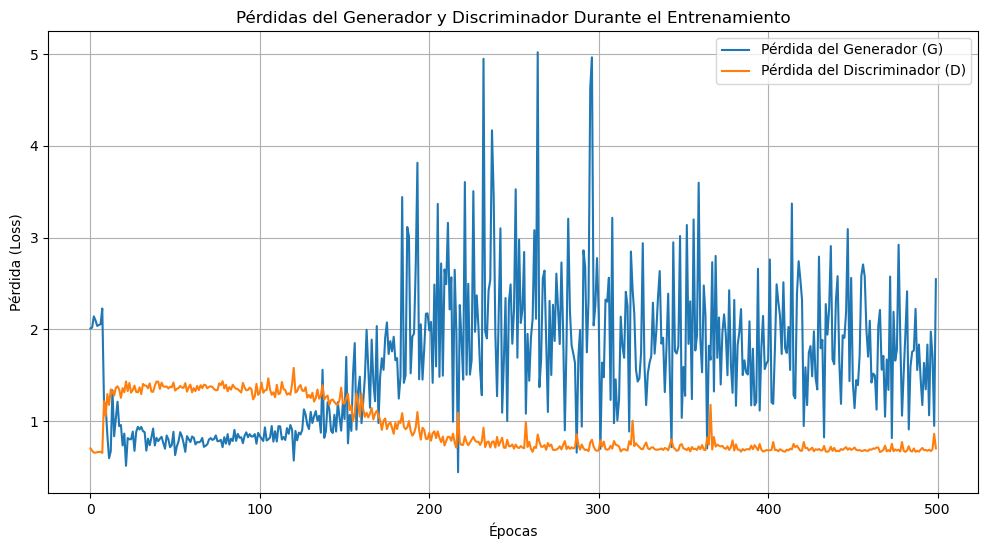

In [33]:
import matplotlib.pyplot as plt

# Crear una figura para el gráfico
plt.figure(figsize=(12, 6))

# Título del gráfico
plt.title("Pérdidas del Generador y Discriminador Durante el Entrenamiento")

# Graficar los datos de las listas
plt.plot(loss_G_list, label="Pérdida del Generador (G)")
plt.plot(loss_D_list, label="Pérdida del Discriminador (D)")

# Etiquetas de los ejes
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")

# Añadir una leyenda para identificar cada línea
plt.legend()

# Añadir una cuadrícula para mejor legibilidad
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [ ]:
import imageio
import os
from IPython.display import Image, display

# --- Configuración del GIF ---
output_dir = "generated_images"  # Carpeta donde se guardan las imágenes de cada época
gif_path = "gan_training_progress.gif" # Nombre del archivo GIF de salida

# Obtener todos los archivos de imagen de la carpeta, ordenados por número de época
# Esto asegura que el GIF se construye en el orden correcto
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir)
                      if f.startswith('fake_samples_epoch_') and f.endswith('.png')],
                     key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

if not image_files:
    print(f"No se encontraron imágenes en la carpeta '{output_dir}'. Asegúrate de que el entrenamiento se haya ejecutado y guardado las imágenes.")
else:
    # Ajusta la duración entre frames
    # Una duración más pequeña hará el GIF más rápido (ej. 0.1 segundos por frame)
    # Una duración más grande hará el GIF más lento (ej. 0.5 segundos por frame)
    durations = [0.2] * len(image_files) # 0.2 segundos por imagen

    # Crear el GIF
    print(f"Creando GIF con {len(image_files)} imágenes...")
    with imageio.get_writer(gif_path, mode='I', duration=durations) as writer:
        for filename in image_files:
            try:
                image = imageio.imread(filename)
                writer.append_data(image)
            except Exception as e:
                print(f"Error al leer la imagen {filename}: {e}")
                continue # Continuar con la siguiente imagen si hay un error

    print(f"GIF guardado en: {gif_path}")

    # Mostrar el GIF en el notebook
    display(Image(filename=gif_path))
    print("GIF mostrado en el notebook.")

In [ ]:
import torch
import torchvision.utils as vutils
from IPython.display import Image, display
import os

# --- 2. Cargar pesos del generador de la época 490 ---
checkpoint_dir = "model_checkpoints"
netG.load_state_dict(torch.load(os.path.join(checkpoint_dir, "netG_epoch_490.pth"), map_location=device))
netG.eval()  # Modo evaluación

# --- 3. Crear carpeta de salida para las imágenes individuales ---
output_folder = "generated_single_images"
os.makedirs(output_folder, exist_ok=True)

# --- 4. Generar y guardar 10 imágenes usando el generador cargado ---
for i in range(10):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Vector latente
    with torch.no_grad():
        fake = netG(noise).detach().cpu()            # Imagen generada

    filename = os.path.join(output_folder, f"generated_cat_{i}.png")
    vutils.save_image(fake[0], filename, normalize=True)  # Guardar imagen

    display(Image(filename=filename))  # Mostrar imagen en Jupyter
